In [47]:
import pandas as pd
import numpy as np
import sys, os

# Return just the first 2 lines to get metadata:
# info = pd.read_csv('290.csv', nrows=1)
# See metadata for specified properties, e.g., timezone and elevation
# timezone, elevation = info['Local Time Zone'], info['Elevation']
# skip step 1 of api because we have the csv files already
df = pd.read_csv('290.csv')

lat = 25
lon = -103.33
year = '2014'
interval = '60'

In [48]:
# Set the time index in the pandas dataframe:
df = df.set_index(pd.date_range('1/1/{yr} 00:30'.format(yr=year), freq=interval+'Min', periods=525600/int(interval)))

print 'shape:',df.shape
df.head()

shape: (8760, 12)


,Unnamed: 0,Year,Month,Day,Hour,Minute,GHI,DHI,DNI,Wind Speed,Temperature,Solar Zenith Angle
2014-01-01 00:30:00,0,2014,1,1,0,30,0,0,0,3.347507,8.164362,174.144205
2014-01-01 01:30:00,1,2014,1,1,1,30,0,0,0,3.224913,7.692804,171.562121
2014-01-01 02:30:00,2,2014,1,1,2,30,0,0,0,2.976812,7.321283,158.040762
2014-01-01 03:30:00,3,2014,1,1,3,30,0,0,0,2.632671,6.985345,144.469369
2014-01-01 04:30:00,4,2014,1,1,4,30,0,0,0,2.350946,6.686761,130.993667


In [49]:
# Print column names
print df.columns.values

['Unnamed: 0' 'Year' 'Month' 'Day' 'Hour' 'Minute' 'GHI' 'DHI' 'DNI'
 'Wind Speed' 'Temperature' 'Solar Zenith Angle']


In [50]:
#import additional module for SAM simulation:
import site
# Use site.addsitedir() to set the path to the SAM SDK API. Set path to the python directory.
site.addsitedir('/Applications/sam-sdk-2016-3-14-r3/languages/python/')
import sscapi
# If this errors, go to line and put absolute path of relevant file.
ssc = sscapi.PySSC()

# Resource inputs for SAM model:
wfd = ssc.data_create()
ssc.data_set_number(wfd, 'lat', lat)
ssc.data_set_number(wfd, 'lon', lon)
# ssc.data_set_number(wfd, 'tz', timezone)
# ssc.data_set_number(wfd, 'elev', elevation)
ssc.data_set_array(wfd, 'year', df.index.year)
ssc.data_set_array(wfd, 'month', df.index.month)
ssc.data_set_array(wfd, 'day', df.index.day)
ssc.data_set_array(wfd, 'hour', df.index.hour)
ssc.data_set_array(wfd, 'minute', df.index.minute)
ssc.data_set_array(wfd, 'dn', df['DNI'])
ssc.data_set_array(wfd, 'df', df['DHI'])
ssc.data_set_array(wfd, 'wspd', df['Wind Speed'])
ssc.data_set_array(wfd, 'tdry', df['Temperature'])

# Create SAM-compliant object
dat = ssc.data_create()
ssc.data_set_table(dat, 'solar_resource_data', wfd)
ssc.data_free(wfd)

# Specify the system Configuration
# Set system capacity in MW
system_capacity = 4
ssc.data_set_number(dat, 'system_capacity', system_capacity)
# Set DC/AC ratio (or power ratio). See https://sam.nrel.gov/sites/default/files/content/virtual_conf_july_2013/07-sam-virtual-conference-2013-woodcock.pdf
ssc.data_set_number(dat, 'dc_ac_ratio', 1.1)
# Set tilt of system in degrees
ssc.data_set_number(dat, 'tilt', 25)
# Set azimuth angle (in degrees) from north (0 degrees)
ssc.data_set_number(dat, 'azimuth', 180)
# Set the inverter efficency
ssc.data_set_number(dat, 'inv_eff', 96)
# Set the system losses, in percent
ssc.data_set_number(dat, 'losses', 14.0757)
# Specify fixed tilt system (1=true, 0=false)
ssc.data_set_number(dat, 'array_type', 0)
# Set ground coverage ratio
ssc.data_set_number(dat, 'gcr', 0.4)
# Set constant loss adjustment
ssc.data_set_number(dat, 'adjust:constant', 0)

# execute and put generation results back into dataframe
mod = ssc.module_create('pvwattsv5')
ssc.module_exec(mod, dat)
df['generation'] = np.array(ssc.data_get_array(dat, 'gen'))

# free the memory
ssc.data_free(dat)
ssc.module_free(mod)

In [51]:
# Divide sum of generation by the number of periods times the system size
df['generation'].sum() / (525600/int(interval) * system_capacity)

0.0

In [52]:
# Total Energy:
df['generation'].sum()

0.0

In [53]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')

def nsrdb_plot(df, i):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax2 = ax.twinx()
    df['90 Degree Zenith'] = 90
    df[['GHI', 'DNI', 'DHI', 'Solar Zenith Angle', '90 Degree Zenith']][i:i+int(interval)].plot(ax=ax, figsize=(15,8), yticks=(np.arange(0,900,100)), style={'90 Degree Zenith': '--','Solar Zenith Angle': '-o', 'DNI': '-o', 'DHI': '-o', 'GHI': '-o'}, legend=False)
    df['generation'][i:i+30].plot(ax=ax2, yticks=(np.arange(0,4.5,0.5)), style={'generation': 'y-o'})
    ax.grid()
    ax.set_ylabel('W/m2')
    ax2.set_ylabel('kW')
    ax.legend(loc=2, ncol=5, frameon=False)
    ax2.legend(loc=1, frameon=False)

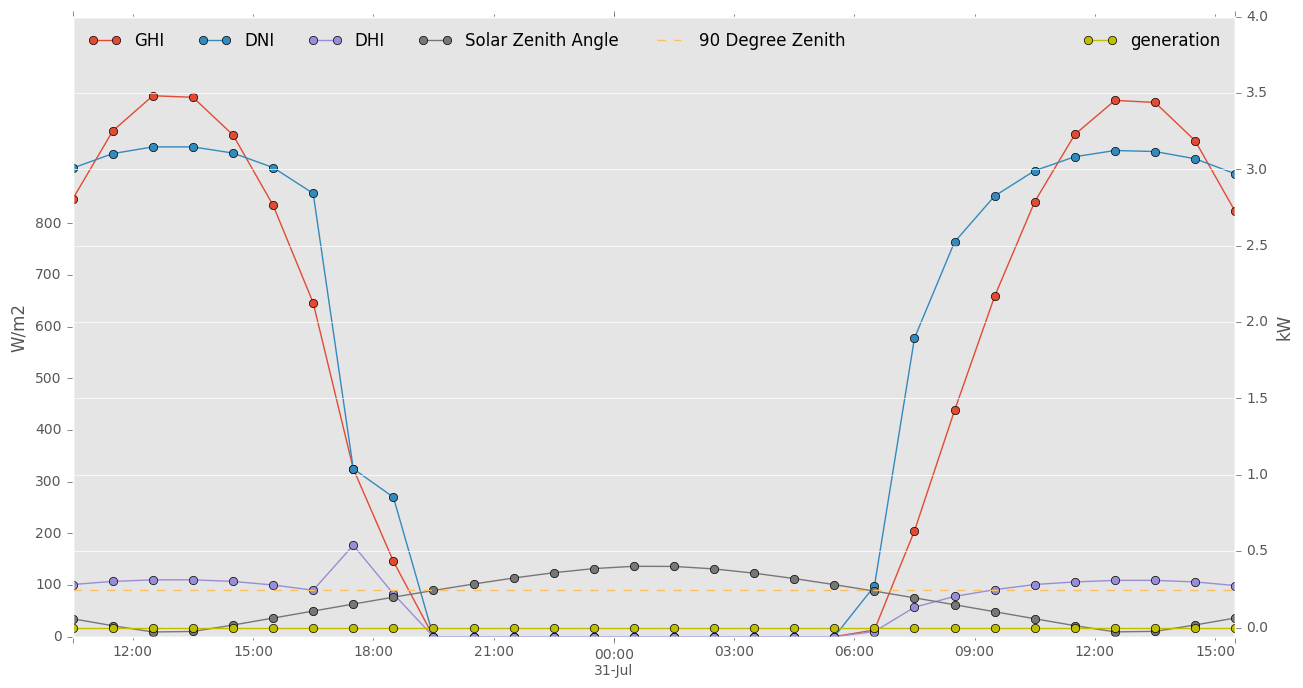

In [54]:
nsrdb_plot(df, 5050)